In [ ]:
from google.colab import files
import zipfile
from google.colab import drive

# drive.mount('/content/drive/')
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import matplotlib.pyplot as plt
Learning_Rate=1e-5
width = 320
height = 240 # image width and height
batchSize=3

In [ ]:
TrainFolder = "/content/drive/MyDrive/Semester 7/Robotics and Computer Vision/Robotics Final Project/Robotics Final Pictures/Pool Table 2/Train"
# TrainFolder = "drive/MyDrive/Rutgers Classes/robotics/Robotics Final Project/Pool Table Pictures/Train//"
ListImages=os.listdir(os.path.join(TrainFolder, "Image"))

In [ ]:
transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor()])
transformAnn=tf.Compose([tf.ToPILImage(),tf.Resize((height,width),tf.InterpolationMode.NEAREST),tf.ToTensor()])

In [ ]:
from PIL.Image import ImageTransformHandler
def ReadRandomImage(): # First lets load random image and  the corresponding annotation
    idx=np.random.randint(0,len(ListImages)) # Select random image
    Img=cv2.imread(os.path.join(TrainFolder, "Image", ListImages[idx]))[:,:,0:3]
    Ball =  cv2.imread(os.path.join(TrainFolder, "Ball", ListImages[idx].replace("jpg","png")),0)
    Table =  cv2.imread(os.path.join(TrainFolder, "Table", ListImages[idx].replace("jpg","png")),0)
    AnnMap = np.zeros(Img.shape[0:2],np.float32)
    if Table is not None:  AnnMap[ Table > 200 ] = 1
    if Ball is not None:  AnnMap[ Ball > 200 ] = 2
    Img=transformImg(Img)
    AnnMap=transformAnn(AnnMap)
    return Img,AnnMap

In [ ]:
# Show all annotation maps to confirm they are being processed correctly
# Used during testing
def ReadEveryImage():
    for idx in range(len(ListImages)):
        Img=cv2.imread(os.path.join(TrainFolder, "Image", ListImages[idx]))[:,:,0:3]
        Ball =  cv2.imread(os.path.join(TrainFolder, "Ball", ListImages[idx].replace("jpg","png")),0)
        Table =  cv2.imread(os.path.join(TrainFolder, "Table", ListImages[idx].replace("jpg","png")),0)
        AnnMap = np.zeros(Img.shape[0:2],np.float32)
        if Table is not None:  AnnMap[ Table > 200 ] = 1
        if Ball is not None:  AnnMap[ Ball > 200 ] = 2
        Img=transformImg(Img)
        AnnMap=transformAnn(AnnMap)
        print(ListImages[idx])
        print(np.count_nonzero(AnnMap==1))
        plt.imshow(AnnMap[0,:,:],cmap='gray')
        plt.show()

In [ ]:
def LoadBatch(): # Load batch of images
    images = torch.zeros([batchSize,3,height,width])
    ann = torch.zeros([batchSize, height, width])
    for i in range(batchSize):
        images[i],ann[i]=ReadRandomImage()
    return images, ann

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True) # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1)) # final layer of 3 classes
Net=Net.to(device)
optimizer=torch.optim.Adam(params=Net.parameters(),lr=Learning_Rate) # Create adam optimizer

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

In [ ]:
device

device(type='cuda')

In [ ]:
for itr in range(501): # Training loop
   images,ann=LoadBatch() # Load taining batch
   images=torch.autograd.Variable(images,requires_grad=False).to(device) # Load image
   ann = torch.autograd.Variable(ann, requires_grad=False).to(device) # Load annotation
   Pred=Net(images)['out'] # make prediction
   Net.zero_grad()
   criterion = torch.nn.CrossEntropyLoss() # Set loss function
   Loss=criterion(Pred,ann.long()) # Calculate cross entropy loss
   Loss.backward() # Backpropogate loss
   optimizer.step() # Apply gradient descent change to weight
   seg = torch.argmax(Pred[0], 0).cpu().detach().numpy()  # Get  prediction classes
   if itr % 1000 == 0: #Save model weight once every 1000 steps into file
        print(itr,") Loss=",Loss.data.cpu().numpy())
        torch.save(Net.state_dict(),   str(itr) + ".pt")

0 ) Loss= 1.1208001


In [ ]:
modelPath = "/content/5000.pt"  # Path to trained model that was saved from training step above
testFolder = "/content/drive/MyDrive/Robotics Final Project/Pool Table 2/Test//"  # Test image
width = 320
height = 240 # image width and height
transformImg = tf.Compose([tf.ToPILImage(), tf.Resize((height, width)), tf.ToTensor()])
Net = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)  # Load net
Net.classifier[4] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))  # final layer of 3 classes (background, table, ball)
Net = Net.to(device)  # Set net to GPU or CPU
Net.load_state_dict(torch.load(modelPath)) # Load trained model
Net.eval() # Set to evaluation mode
print("Network ready")

NameError: ignored

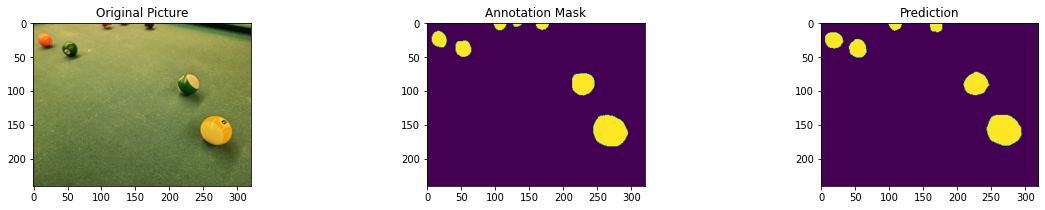

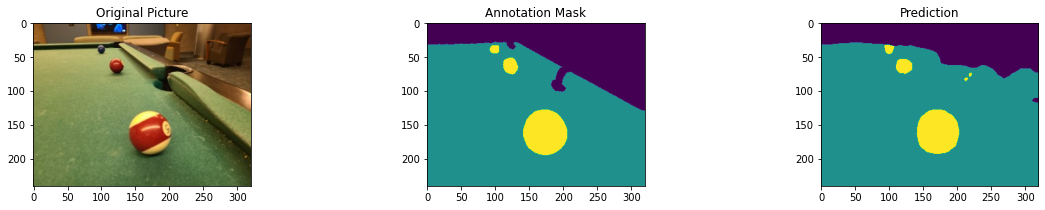

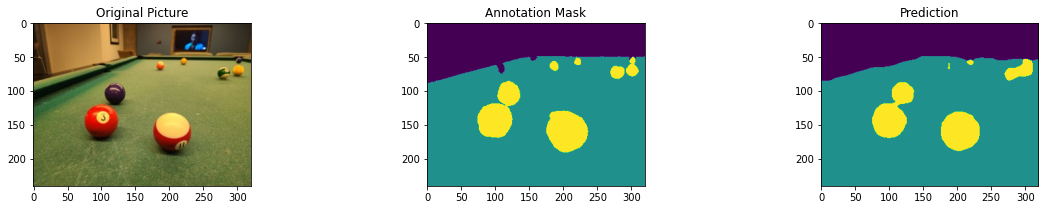

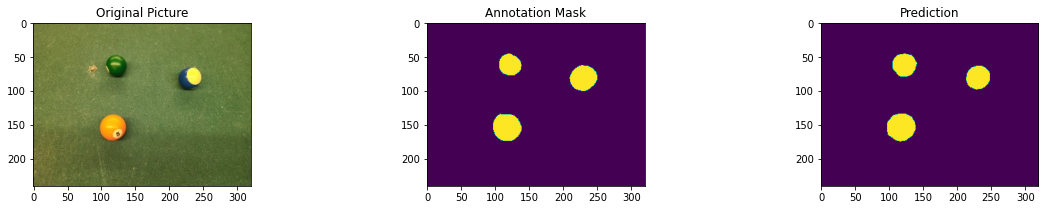

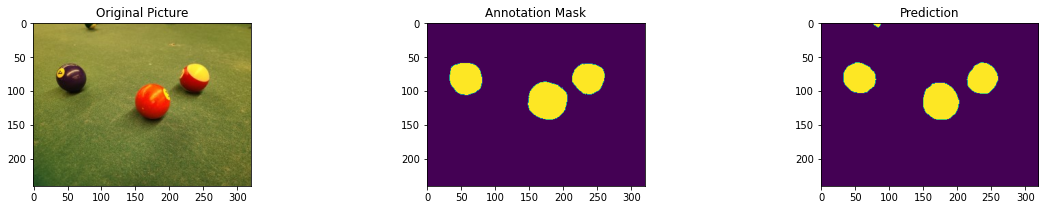

In [ ]:
ListImages=os.listdir(os.path.join(testFolder, "Image"))
allAnnMaps = []
allSegs = []
plt.rcParams["figure.figsize"] = (20,3)
for idx in range(len(ListImages)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    Img=cv2.imread(os.path.join(testFolder, "Image", ListImages[idx]))[:,:,0:3]
    height_orgin, widh_orgin, d = Img.shape
    Ball =  cv2.imread(os.path.join(testFolder, "Ball", ListImages[idx].replace("jpg","png")),0)
    Table =  cv2.imread(os.path.join(testFolder, "Table", ListImages[idx].replace("jpg","png")),0)
    AnnMap = np.zeros(Img.shape[0:2],np.float32)
    if Table is not None:  AnnMap[ Table > 200 ] = 1
    if Ball is not None:  AnnMap[ Ball > 200 ] = 2
    ax1.imshow(Img[:,:,::-1])  # Show image
    ax1.set_title("Original Picture")
    # plt.show()
    Img=transformImg(Img)
    AnnMap=transformAnn(AnnMap)
    ax2.imshow(AnnMap[0,:,:])
    ax2.set_title("Annotation Mask")
    allAnnMaps.append(AnnMap[0,:,:])
    # plt.show()
    Img = torch.autograd.Variable(Img, requires_grad=False).to(device).unsqueeze(0)
    with torch.no_grad():
        Prd = Net(Img)['out']  # Run net
    Prd = tf.Resize((height_orgin,widh_orgin))(Prd[0]) # Resize to origninal size
    seg = torch.argmax(Prd, 0).cpu().detach().numpy()  # Get  prediction classes
    allSegs.append(seg)
    ax3.imshow(seg)  # display image
    ax3.set_title("Prediction")
    plt.show()

The above figure shows the original picture, the annotated segmentation mask that we manually created, as well as the predicted segmentation. As seen, the predictions are pretty good. However, merely looking at it is not enough to deem that it is a good model. To confirm this, metrics have to be calculated.

In [ ]:
conf_matrix = np.zeros((3,3))
for idx in range(len(ListImages)):
  AnnMap = allAnnMaps[idx]
  seg = allSegs[idx]
  for i in range(len(AnnMap)):
    for j in range(len(AnnMap[0])):
      conf_matrix[(int)(AnnMap[i,j]), (int)(seg[i,j])] += 1


In [ ]:
# Class 0: Background
# Class 1: Table
# Class 2: Ball
conf_matrix

array([[3.46600e+04, 7.68710e+04, 4.58000e+02],
       [6.84000e+02, 2.46286e+05, 7.67000e+02],
       [3.80000e+01, 2.07400e+03, 2.21620e+04]])

In [ ]:
tp = np.zeros(3)
tn = np.zeros(3)
fp = np.zeros(3)
fn = np.zeros(3)
accuracy = np.zeros(3)
precision = np.zeros(3)
recall = np.zeros(3)
f_score = np.zeros(3)
for i in range(3):
  tp[i] = conf_matrix[i,i]
  tn[i] = np.sum(conf_matrix[i,:]) + np.sum(conf_matrix[:,i]) - 2 * conf_matrix[i,i]
  fp[i] = np.sum(conf_matrix[i,:]) - conf_matrix[i,i]
  fn[i] = np.sum(conf_matrix[:,i]) - conf_matrix[i,i]
  accuracy[i] = ( tp[i] + tn[i] ) / (tp[i] + tn[i] + fp[i] + fn[i])
  precision[i] = tp[i] / ( tp[i] + fp[i] )
  recall[i] = tp[i] / ( fn[i] + tp[i] )
  f_score[i] = 2 * precision[i] * recall[i] / ( precision[i] + recall[i] )

print("Classes:\t [Background Table\tBall]", )
print("Accuracy:\t", accuracy)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F Score:\t", f_score)
print("Average Accuracy: " + str(np.average(accuracy)))
print("Average Precision: " + str(np.average(precision)))
print("Average Recall: " + str(np.average(recall)))
print("Average F Score: " + str(np.average(f_score)))
print("Loss during training: " + str(Loss.data.cpu().numpy()))

Classes:	 [Background Table	Ball]
Accuracy:	 [0.59084619 0.80250468 0.8842766 ]
Precision:	 [0.30949468 0.99414298 0.91299333]
Recall:		 [0.97959414 0.75726484 0.94762047]
F Score:	 [0.47037748 0.85968501 0.92998468]
Average Accuracy: 0.7592091545626228
Average Precision: 0.7388769969938845
Average Recall: 0.8948264844017076
Average F Score: 0.753349058253492
Loss during training: 0.024355028
